# Factor analysis of nonverbal behavior



### Setup
The following code reads the required packages, the R version under which I did the project, and the location of loaded packages locally.

In [1]:
req <- readLines("../requirements.txt")
proj_version <- "R version 3.6.1 (2019-07-05)"
p<-.libPaths()
`%notin%` <- Negate(`%in%`)

This lets you know if the local version of R is the same as when the project was make.

In [2]:
if (proj_version != version$version.string){
  print(paste("You have ", version$version.string, ". This project was created with R version 3.6.1 (2019-07-05). Some packages may not install or work properly"))
} else {
  print("You have the same version of R as was used in this project")
}

[1] "You have the same version of R as was used in this project"


This installs and attaches required packages except semPlot, which doesn't seem to work through conda

In [3]:
req<-req[1:6]
for (i in 1:length(req)){
  pkg<-req[[i]]
  if (pkg %notin% rownames(installed.packages())){
    install.packages(pkg, p)
  }
  if (pkg %in% rownames(installed.packages()) & pkg %notin% loadedNamespaces()){
    library(pkg, character.only = T)
    print(paste("Attaching package:", pkg))
  }
  if (pkg %notin% rownames(installed.packages())){
    print(paste("Error installing ", pkg, ". Check Warnings."))
  }
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



[1] "Attaching package: dplyr"
[1] "Attaching package: tidyr"
[1] "Attaching package: psych"
[1] "Attaching package: GPArotation"


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
sROC 0.1-2 loaded


[1] "Attaching package: MVN"



Attaching package: ‘polycor’

The following object is masked from ‘package:psych’:

    polyserial



[1] "Attaching package: polycor"


### Load and clean the data

Next, this reads in the data.

In [ ]:
messy_data<-read.delim("NIS_data/data.csv", na.strings = c("", "NA"))

Clean the data, removing possibly invalid responses, and retaining only the data of interest (the question ratings).

In [ ]:
NIS_clean<-messy_data[1:5000, ]%>% #take just the first 5,000 observations of this massive dataset
  select(c("Q1", "Q2", "Q3","Q4", "Q5", "Q6", "Q7",  "Q8",  "Q9",  "Q10", "Q11", "Q12", "Q13", "Q14", "Q15", "Q16", "Q17", "Q18", "Q19", "Q20", "Q21", "Q22", "Q23", "Q24", "Q25", "Q26", "VCL1", "VCL2", "VCL3", "VCL4", "VCL5", "VCL6", "VCL7", "VCL8", "VCL9",  "VCL10",  "VCL11", "VCL12",  "VCL13", "VCL14", "VCL15",  "VCL16"))%>% #select the actual columns, as well as the word recognition columns 
  filter_at(vars(c("VCL6", "VCL9","VCL12")), all_vars(.==0))%>% #these three variables are not real words. This keeps only observations where only all three were marked as unknown.
  filter_at(vars(starts_with("Q")), all_vars(.!=0))%>% #0 is not a valid option in the 1-5 likert scale for NIS items. This keeps only observations where none of the Qs were answered with 0.
  select(starts_with("Q"))%>% #retains only the NIS questions
  mutate_all(as.numeric)

This assesses the multivariate normality of the data. Data is not normallly distributed, which means we have to use Principal axis factoring method.

In [ ]:
mvn(NIS_clean[1:length(NIS_clean), ], mvnTest = "hz", multivariatePlot = "qq")$multivariateNormality #takes only 5,000 obs

### Now we are ready to run factor analysis
Because we are working with Likert rating data, we use the polychoric correlation matrix. Polychoric correlations estimate the theorized correlations between pairs of ordinal variables. This matrix will be used in place of a correlation matrix in the factor analysis. 

In [ ]:
NIS_m<-data.matrix(NIS_clean) #save data as matrix
pcor<-polycor::hetcor(NIS_m, ML = T)$correlations #extract the polychoric correlation matrix

To determine how many factors to extract, parallel analysis compares the scree polt of successive eigenvalues of the observed data to a random matrix of the same size. 

In [ ]:
psych::fa.parallel(pcor, n.obs = 3633, fm = "pa", fa = "fa")

The following code performs and prints the factor analysis.
- The factor method is Principal Axis ("pa"). This method is best for non-normally distributed data.
- The rotation is "oblimin", a standard oblique rotation, meaning that the it allows the extracted factors to be correlated with each other. I chose "oblimin" because factors in this dataset are all related to a common construct and are likely to be correlated. The purpose of rotations is to "obtain simple structure in order to enhance interpretability of the solution" (Norris). 

In [ ]:
fac <- psych::fa(pcor, nfactors=8, fm="pa", n.obs=3633, rotate="oblimin")

Is this modela a good fit for the data?

In [ ]:
print(paste("Root mean square of the residuals:", fac$rms))
print(paste("Tucker Lewis index:", fac$TLI))
print(paste("RMSEA:", fac$RMSEA[1]))

The above model is a good fit: root mean square of residuals is close to 0, the Tucker Lewis index is close to 1, and RMSEA index is < 0.05.

### Interpreting the factor analysis

Next I explored which questions ended up in which factor.

The following code saves the loadings to a dataFrame and renames the columns. 

In [ ]:
fa_loadings <- fac$loadings%>%
  as.table()%>%
  as.data.frame()%>%
  filter(Freq>=0.3 | Freq<=-0.3)
colnames(fa_loadings)<-c("Question", "Factor", "Loading")
levels(fa_loadings$Factor)<-c("PA1","PA2","PA3","PA4","PA5","PA6","PA7","PA8")

This sets up a list that allows you to find the text of each question using questions$questionNumber

In [ ]:
#set up empty list:
questions<-vector(mode = "list", length =26)

#set up an empty list of names:
qnames<-vector(mode = "character", length = 26)

#read in the the part of the codebook that lists the questions to a temporary file:
temp<-readLines("NIS_data/codebook.txt")[9:34]

#the first item of each line in temp is the question # and the 2nd item is the question text:
for (i in 1:26){
  qnames[i]<-strsplit(temp[i], '\t')[[1]][1]
  questions[i]<-strsplit(temp[i], '\t')[[1]][2]
  names(questions)<-qnames
}

#example:
questions$Q16

This adds a column to the fa_loadings DataFrame that is the text of each question.

In [ ]:
fa_loadings$Question_txt<-factor(NA,levels = c("I use my hands and arms to gesture while talking to people. ","I touch others on the shoulder or arm while talking to them. ","I use a monotone or dull voice while talking to people. ","I look over or away from others while talking to them. ","I move away from others when they touch me while we are talking. ","I have a relaxed body position when I talk to people. ", "I frown while talking to people. ","I avoid eye contact while talking to people. ", "I have a tense body position while talking to people. ","I sit close or stand close to people while talking with them. ","My voice is monotonous or dull when I talk to people. ","I use a variety of vocal expressions when I talk to people. ", "I gesture when I talk to people. ","I am animated when I talk to people. ","I have a bland facial expression when I talk to people. ","I move closer to people when I talk to them. ","I look directly at people while talking to them. ","I am stiff when I talk to people. ","I have a lot of vocal variety when I talk to people. ","I avoid gesturing while I am talking to people. ","I lean toward people when I talk to them. ","I maintain eye contact with people when I talk to them. ","I try not to sit or stand close to people when I talk with them. ","I lean away from people when I talk to them. ","I smile when I talk to people. ","I avoid touching people when I talk to them."))

for (i in unique(fa_loadings$Question)){
  fa_loadings$Question_txt[fa_loadings$Question==i]<-as.character(questions[i])
}
fa_loadings<-arrange(fa_loadings, Factor)
head(fa_loadings)

### We can also visualize the factor loadings

In [ ]:
#semPlot doesn't seem to work in jupyter notebooks, but here is the code to make the below plot
#model<-semPlot::semPlotModel(fac$loadings)
#semPlot::semPaths(model,what="par",whatLabels="est", rotation=4, minimum=0.3, sizeMan=25, sizeMan2 = 2, edge.width =.3, nodeLabels = c("look over or away from others", "avoid eye contact", "look directly", "maintain eye contact", "using gestures", "gesture", "am animated", "avoid gesturing", "sit or stand close", "move closer", "lead towards", "try not to sit or stand close", "lean away","use monotone or dull voice" ," monotonous voice", "bland facial expressions","relaxed body position", "tense body position","stiff","touch others on the shoulder", "move away when others touch me", "avoid touching others", "frown", "smile", "vocal expressions", "vocal variety", "PA4", "PA2", "PA3","PA1", "PA5", "PA6", "PA8", "PA7"), label.cex=(.5), label.scale=F)

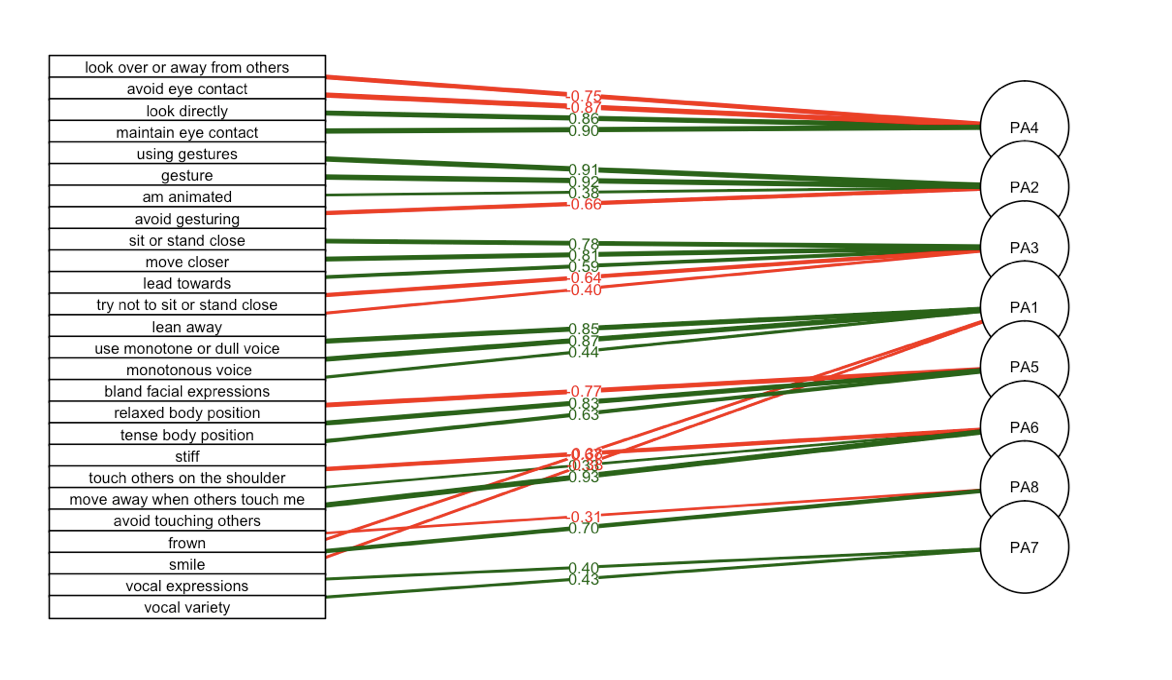

#### - Red lines indicate negative loadings between particular questions (abbreviated) and green lines indicate positive loadings.

#### - I like to think of factor names based on positive loadings, because its more intuitive. Someone who has a high rating of a question that loads negatively onto a factor would have a lower rating of that factor altogether.

#### - We could consider calling PA1 "Flat affect", PA2 "Talking with hands", PA3 "Close physical proximity", PA4 "Strong eye contact", PA5 "Stiff body position", PA6 "Touch", PA7 "Vocal expressiveness", PA8 "Positive affect"

#### - Based on this result, we may consider removing PA8 and including those questions in PA4, considering that the only questions that load on PA8 also load on PA4. 